<ipython-input-4-c5ef4651865b>:28: FutureWarning: The default value of regex will change from True to False in a future version.
  return col.apply(lambda x: nltk.word_tokenize(x)) \


              precision    recall  f1-score   support

        real       0.99      1.00      0.99      4296
        fake       1.00      0.99      0.99      4558

    accuracy                           0.99      8854
   macro avg       0.99      0.99      0.99      8854
weighted avg       0.99      0.99      0.99      8854

[[4276   20]
 [  27 4531]]


C:\Users\share\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=[0, 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


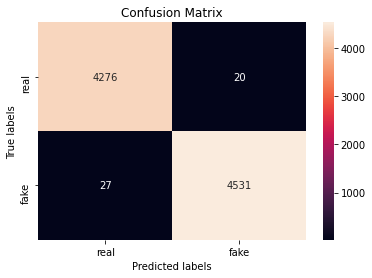

In [4]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn import tree, metrics
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns 
import nltk

# load data
df_fake_news = pd.read_csv("dataset/ISOTNews/Fake.csv")
df_real_news = pd.read_csv("dataset/ISOTNews/True.csv")
# add is Fake attribute
df_fake_news["isFake"]=1
df_real_news["isFake"]=0
# combine data
df_all_news = pd.concat([df_fake_news,df_real_news])
# filter out empty news
df_all_news['textWordCount'] =  df_all_news['text'].apply(lambda x: len(nltk.word_tokenize(x)))
df_all_news = df_all_news[df_all_news['textWordCount']>0]

# clean up text before tfidf vectorization
def preprocessing(col):
    from nltk.stem.wordnet import WordNetLemmatizer
    stopwords = nltk.corpus.stopwords.words('english')
    lem = WordNetLemmatizer()
    return col.apply(lambda x: nltk.word_tokenize(x)) \
    .apply(lambda x: " ".join([lem.lemmatize(w.lower()) for w in x if w.lower() not in stopwords])) \
    .str.replace('[^\w\s]','')

df_all_news['cleanupText'] =  preprocessing(df_all_news['text'])

# split dataset into 80% training and 20% testing
train_x, test_x, train_y, test_y  = train_test_split(df_all_news['cleanupText'],df_all_news['isFake'], test_size=0.2, random_state = 1)

model = Pipeline([
    ('vect', TfidfVectorizer(ngram_range=(1,3))),
    ('clf', tree.DecisionTreeClassifier(criterion='gini',max_depth=30))
])
model.fit(train_x, train_y)

def getClassificationReport(model, test_x,test_y):
    pred = model.predict(test_x)
    labels = ['real','fake']
    report = classification_report(test_y,pred,target_names=labels)
    print(report)
    cm = metrics.confusion_matrix(test_y, pred, [0,1])
    print(cm)

    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['real', 'fake']); ax.yaxis.set_ticklabels(['real','fake']);
    
getClassificationReport(model,test_x, test_y)

In [20]:
articles = test_x.iloc[-60:-50]
true_labels = test_y.iloc[-60:-50]
pred = model.predict(articles)



In [33]:
# check classification for 10 articles
index = articles.index
for i in range(len(articles)):
    print(str(i))
    #print(articles[index[i]])
    label = 'Fake'
    if true_labels[index[i]] == 0:
        label = 'Real'
    prediction = 'Fake'
    if pred[i] == 0:
        prediction = 'Real'
    print('Label:'+label)
    print('Prediction:'+ prediction)
    matched = False
    if prediction == label:
        matched = True
    print('Classified correctly:'+ str(matched))

0
Label:Fake
Prediction:Fake
Classified correctly:True
1
Label:Real
Prediction:Real
Classified correctly:True
2
Label:Fake
Prediction:Fake
Classified correctly:True
3
Label:Fake
Prediction:Fake
Classified correctly:True
4
Label:Fake
Prediction:Fake
Classified correctly:True
5
Label:Real
Prediction:Real
Classified correctly:True
6
Label:Real
Prediction:Real
Classified correctly:True
7
Label:Real
Prediction:Real
Classified correctly:True
8
Label:Fake
Prediction:Fake
Classified correctly:True
9
Label:Fake
Prediction:Fake
Classified correctly:True


In [57]:

import textstat as st
from spellchecker import SpellChecker
import nltk
import textblob as tb
from sklearn import tree
import numpy as np

def countAllCapitalWordInText(text):
    return np.sum([x.isupper() for x in text.split()])

def countSpellingError(text):
    spell = SpellChecker()
    error = 0
    tokens = nltk.word_tokenize(text)
    for token in tokens:
        if token.lower() not in spell:
            error +=1
    return error

def lexical_diversity(text):
    words = nltk.word_tokenize(text)
    diversity = len(set(words))/len(words)
    return diversity


def extractFeatures(title,text):
    df = pd.DataFrame([{'title':title,'text':text}])
    df['numExclaimsInTitle'] =  df['title'].str.count("!")
    df['allCapsInTitle'] = df['title'].apply(countAllCapitalWordInText)
    df['titleWordCount'] = df['title'].apply(lambda x: len(nltk.word_tokenize(x)))
    df['textWordCount'] = df['text'].apply(lambda x: len(nltk.word_tokenize(x)))
    df['textSentenceCount'] = df['text'].apply(lambda x: len(nltk.sent_tokenize(x)))
    #df['averageWordCountInSentence'] = df.assign(averageWordCountInSentence = df.apply(lambda x: x['textWordCount']/x.textSentenceCount, axis=1))
    df["readability"] = df['text'].apply(st.flesch_reading_ease)
    df["spellings_error"] = df['text'].apply(countSpellingError)
    df["lexicalDiversity"] = df['text'].apply(lexical_diversity)
    df['text_word_tokens'] = df['text'].apply(lambda x: list(nltk.word_tokenize(x)))
    df['POS_text'] = df['text_word_tokens'].apply(nltk.pos_tag)
    df['NounCount'] = df['POS_text'].apply(lambda x: len([t[0] for t in x if t[1].startswith('NN')]))
    df['VerbCount'] = df['POS_text'].apply(lambda x: len([t[0] for t in x if t[1].startswith('VB')]))
    df['PronounCount'] = df['POS_text'].apply(lambda x: len([t[0] for t in x if t[1].startswith('PRP')]))
    df['AdjectiveCount'] = df['POS_text'].apply(lambda x: len([t[0] for t in x if t[1].startswith('JJ')]))
    df['ConjunctionCount'] = df['POS_text'].apply(lambda x: len([t[0] for t in x if t[1].startswith('CC')]))
    df['ModalCount'] = df['POS_text'].apply(lambda x: len([t[0] for t in x if t[1].startswith('MD')]))
    df['NumericCount'] = df['POS_text'].apply(lambda x: len([t[0] for t in x if t[1].startswith('CD')]))
    df['ProperNounCount'] = df['POS_text'].apply(lambda x: len([t[0] for t in x if t[1].startswith('NNP')]))
    df['PastTenseCount'] = df['POS_text'].apply(lambda x: len([t[0] for t in x if t[1].startswith('VBD')]))
    df['AdverbCount'] = df['POS_text'].apply(lambda x: len([t[0] for t in x if t[1].startswith('RB')]))
    df['ComparativeCount'] = df['POS_text'].apply(lambda x: len([t[0] for t in x if t[1] in ['JJR','JJS','RBR','RBS']]))
    df['cleanupText'] = preprocessing(df['text'])
    df['subjectivity'] = df['cleanupText'].apply(lambda x: tb.TextBlob(x).sentiment.subjectivity)
    df['polarity'] = df['cleanupText'].apply(lambda x: tb.TextBlob(x).sentiment.polarity)
    return df

def validateNews(title,text):
    features = extractFeatures(title,text)
    prediction = model.predict(features['cleanupText'])
    if prediction[0] == 0:
        print ("Real news")
    else:
        print("Suspect this news is fake news, please check on it")





In [58]:
title ='How to Blow $700 Million: Al Jazeera America Finally Calls it Quits'
text = '21st Century Wire says Al Jazeera America will go down in history as one of the biggest failures in broadcast media history.Ever since the US and its allies began plotting to overthrow Libya and Syria, Al Jazeera has deteriorated from a promising international news network in 2003   into what it has become in 2016   a full-blown agit prop media shop for the US State Department and the Pentagon. In fact, US Military Central Command (CENTCOM) for the Middle East region is located in Qatar s capital of Doha, conveniently located just down the road from Al Jazeera s headquarters. Nice and cozy.Al Jazeera s role in promoting  regime change  and the destablization of Syria is now recorded history, as are its many shameful exhibitions of media fakery.The Qatari royals tried to expand propaganda operations into North America, but no matter how much money they threw at it (and those royals just love throwing money at things to try and get them to work), no one cared about it, much less watched it. I know this will be a massive disappointment for everyone here who has worked tirelessly for our long-term future. The decision that has been made is in no way because AJAM has done anything but a great job,  reads a company email from CEO Al Anstey, obtained by Politico.Indeed, they tried everything it seems, just short of paying Americans to watch their programs Al Jazeera America to close down https://t.co/EmFjBw9uC1 pic.twitter.com/HDea8ujTPt  Al Jazeera America (@ajam) January 13, 2016In 2012, the Qatari-owned Al Jazeera purchased Current TV from Al Gore for an inflated $500 million. Wait, it gets worse MONEY FOR NOTHING: Gore got fat off the AJAM deal.In addition to the $500 million which Doha blew on buying Gore s lemon, Current TV, the Qataris have spent at least $50 million per year between 2012   2015, along with many millions spent on advertising AJAM on other network slots, online ads, along with billboards and print media promotions. This was the Qataris   easy  ticket on to US cable and satellite networks. Boy, did Gore pull a fast one there.  In total, you would be looking at $700 million for the whole party. At its apex, AJAM would be lucky to pull in 30,000 viewers during prime time   which really amounts to a  nothing  market share.With all that money, and considering the hundreds of staff and  media executives  and producers they employed, it s safe to say that someone(s) did not have a clue what they were doing.What a colossal joke.On the bright side, the Qataris can always blame the collapse in oil prices for their lack of spare cash to fund their propaganda mills.READ MORE MAINSTREAM MEDIA EPIC FAILS AT: 21st Century Wire MSM Watch'
validateNews(title,text)
             
            

Suspect this news is fake news, please check on it


<ipython-input-4-c5ef4651865b>:28: FutureWarning: The default value of regex will change from True to False in a future version.
  return col.apply(lambda x: nltk.word_tokenize(x)) \
